In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [141]:
dfs = pd.read_excel('C://Users//vikal//source//vec.xlsx', sheet_name='Лист1')
dfs

,Название,id,T1,T2,T3,T4,Техническое состояние двигателя
0,10011 KOMATSU PC55MR Экскаватор 5914рт78,346,56,73,69,100,3
1,102111 УРАЛ Кран о570ат198,942,63,60,71,91,3
2,102135 УРАЛ Кран о563ат198,171,59,57,80,86,3
3,102140 УРАЛ Кран о199ек198,158,59,66,64,78,2
4,102168 УРАЛ Кран о139вн198,221,58,52,71,101,1
...,...,...,...,...,...,...,...
154,93888 Mercedes-3341 Самосвал о488еа198,152,61,51,70,121,3
155,93900 Mercedes-3341 Самосвал о176ев198,604,56,70,65,87,2
156,93909 Mercedes-3341 Самосвал о345во198,356,61,72,59,114,2
157,93923 Mercedes-3341 Самосвал о419еа198,784,59,56,74,92,1


In [142]:
X = dfs.drop(['Название', 'id'], axis = 1)
y = X['Техническое состояние двигателя']
X = X.drop(['Техническое состояние двигателя'], axis = 1)

In [143]:
# toPredict_signals = read_signals().drop(['p0', 'p1', 'p2', 'p3'], axis = 1)
# toPredict_signals.loc[toPredict_signals['cluster']!=-1.0, 'cluster'] = np.NaN
# toPredict_signals = toPredict_signals.dropna(subset='cluster').drop(['cluster'], axis = 1)
# toPredict_signals

In [144]:
#создание тензоров
# X_train = torch.FloatTensor(train_signals.to_numpy())
# y_train = torch.LongTensor(train_signals_classes.astype(int).to_numpy())
# X_main = torch.FloatTensor(toPredict_signals.to_numpy())
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    shuffle=True)


X_train = torch.FloatTensor(X_train.to_numpy())
y_train = torch.LongTensor(y_train.astype(int).to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())
y_test = torch.LongTensor(y_test.astype(int).to_numpy())




In [145]:
#реализуем класс нейросети: нейросеть состоит из 2 слоев (1 скрытый)
class Cluster(torch.nn.Module): #наследуем свойства от модлуля nn.Module
    def __init__(self, n_hidden_neurons): #кол-во скрытых нейронов параметре
        super(Cluster, self).__init__()
        
        self.fc1 = torch.nn.Linear(4, n_hidden_neurons) #1 слой из 4 входов (4 признака)
        self.activ1 = torch.nn.Sigmoid()#функция активации (я исполоьзую сигмоиду)
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 4)
        self.sm = torch.nn.Softmax(dim=1) #принимает нейроны и выдает вероятности классов
        
    #данная функция реализует граф нейронной сети
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activ1(x)
        x = self.fc2(x) 
        x = self.activ2(x)
        x = self.fc3(x) 
        return x
        
    #считаем вероятности через Softmax
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
        
cluster = Cluster(5) #передаю количество скрытых нейронов

In [146]:
loss = torch.nn.CrossEntropyLoss() #инициализирую функцию потерь

optimizer = torch.optim.Adam(cluster.parameters(), 
                             lr=1.0e-3)   #метод вычисления градиентных шагов (туда мы передаем веса transport.parameters())

In [147]:
#обучение нейронной сети
#несмотря на то что датасет маленький, я все равно хочу обучить нейронную сеть по частям (по батчам), так как раз-таки именно этот метод обучения чаще всего используется в реальной жизни, когда обрабатываются большие массивы данных

batch_size = 10 #задаем размер одной части

test_accuracy_history = []
test_loss_history = []

#перемешивание датасета каждую эпоху (итерация просмотра всех данных)
for epoch in range(5000):
    order = np.random.permutation(len(X_train)) #получение порядка индексов в случайном порядке, которые нужно применить к данным
    for start_index in range(0, len(X_train), batch_size): #из датасета вырезаем участки длиной batch_size
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size] #вычисление индексов, соответсвующих текущей части
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = cluster.forward(x_batch) #пропускаем данные через нейросеть
        
        loss_value = loss(preds, y_batch) #считаем функцию потерь
        loss_value.backward() #считаем производную функции потерь
        
        optimizer.step() #делаем шаг градиентного спуска
    
    test_preds = cluster.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.2917)
tensor(0.4167)
tensor(0.4167)
tensor(0.4167)
tensor(0.4167)
tensor(0.4167)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4375)
tensor(0.4

tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4375)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4792)
tensor(0.4583)
tensor(0.4375)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4

tensor(0.4792)
tensor(0.5000)
tensor(0.5000)
tensor(0.4583)
tensor(0.5000)
tensor(0.4792)
tensor(0.4792)
tensor(0.5000)
tensor(0.4583)
tensor(0.4583)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.4583)
tensor(0.4583)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.4792)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.4792)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.4792)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.5000)
tensor(0.4792)
tensor(0.5000)
tensor(0.5000)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.5000)
tensor(0.4792)
tensor(0.5000)
tensor(0.5

tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.4583)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.4792)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5

tensor(0.4583)
tensor(0.4167)
tensor(0.4792)
tensor(0.5000)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4167)
tensor(0.4792)
tensor(0.4792)
tensor(0.4167)
tensor(0.4792)
tensor(0.4167)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4375)
tensor(0.4583)
tensor(0.4375)
tensor(0.4167)
tensor(0.4583)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.5000)
tensor(0.4583)
tensor(0.4583)
tensor(0.4375)
tensor(0.4792)
tensor(0.4583)
tensor(0.4375)
tensor(0.4792)
tensor(0.4792)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4375)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.4792)
tensor(0.5000)
tensor(0.5417)
tensor(0.5208)
tensor(0.5208)
tensor(0.5208)
tensor(0.5000)
tensor(0.5208)
tensor(0.5417)
tensor(0.5417)
tensor(0.5000)
tensor(0.5208)
tensor(0.5417)
tensor(0.5

tensor(0.4167)
tensor(0.5000)
tensor(0.4792)
tensor(0.5208)
tensor(0.4375)
tensor(0.5000)
tensor(0.4792)
tensor(0.4792)
tensor(0.5000)
tensor(0.4583)
tensor(0.4583)
tensor(0.5000)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.3958)
tensor(0.5208)
tensor(0.5000)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4792)
tensor(0.4375)
tensor(0.5208)
tensor(0.5417)
tensor(0.5000)
tensor(0.5000)
tensor(0.4583)
tensor(0.4583)
tensor(0.5000)
tensor(0.4583)
tensor(0.4375)
tensor(0.4792)
tensor(0.5000)
tensor(0.4167)
tensor(0.4583)
tensor(0.4792)
tensor(0.5000)
tensor(0.4583)
tensor(0.5000)
tensor(0.5000)
tensor(0.4583)
tensor(0.3958)
tensor(0.4167)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.5417)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4375)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4

tensor(0.3750)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4375)
tensor(0.4167)
tensor(0.3750)
tensor(0.4167)
tensor(0.4375)
tensor(0.4167)
tensor(0.3750)
tensor(0.3750)
tensor(0.3750)
tensor(0.4167)
tensor(0.4167)
tensor(0.3750)
tensor(0.3750)
tensor(0.4583)
tensor(0.4583)
tensor(0.4375)
tensor(0.4375)
tensor(0.4167)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4375)
tensor(0.4583)
tensor(0.4375)
tensor(0.4167)
tensor(0.4375)
tensor(0.4583)
tensor(0.3958)
tensor(0.3750)
tensor(0.3542)
tensor(0.3750)
tensor(0.4167)
tensor(0.3542)
tensor(0.3750)
tensor(0.3542)
tensor(0.3750)
tensor(0.3750)
tensor(0.3750)
tensor(0.3542)
tensor(0.3750)
tensor(0.3750)
tensor(0.4167)
tensor(0.4583)
tensor(0.4167)
tensor(0.4375)
tensor(0.3750)
tensor(0.3750)
tensor(0.4167)
tensor(0.4167)
tensor(0.3958)
tensor(0.3958)
tensor(0.3750)
tensor(0.4375)
tensor(0.4583)
tensor(0.4375)
tensor(0.4167)
tensor(0.4375)
tensor(0.4167)
tensor(0.4375)
tensor(0.4583)
tensor(0.3542)
tensor(0.3958)
tensor(0.4

tensor(0.3750)
tensor(0.3750)
tensor(0.3542)
tensor(0.3750)
tensor(0.3750)
tensor(0.3750)
tensor(0.3542)
tensor(0.3542)
tensor(0.3333)
tensor(0.4375)
tensor(0.3750)
tensor(0.3542)
tensor(0.3333)
tensor(0.3750)
tensor(0.3958)
tensor(0.3958)
tensor(0.3542)
tensor(0.3750)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3750)
tensor(0.3750)
tensor(0.3750)
tensor(0.3750)
tensor(0.4167)
tensor(0.4167)
tensor(0.4167)
tensor(0.3333)
tensor(0.3542)
tensor(0.3750)
tensor(0.3542)
tensor(0.3958)
tensor(0.4167)
tensor(0.3958)
tensor(0.3750)
tensor(0.3542)
tensor(0.3750)
tensor(0.3542)
tensor(0.3542)
tensor(0.3750)
tensor(0.3750)
tensor(0.3542)
tensor(0.3750)
tensor(0.3750)
tensor(0.3125)
tensor(0.3542)
tensor(0.4583)
tensor(0.3958)
tensor(0.3542)
tensor(0.3542)
tensor(0.3542)
tensor(0.3125)
tensor(0.3542)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3750)
tensor(0.3750)
tensor(0.4167)
tensor(0.3958)
tensor(0.3750)
tensor(0.3750)
tensor(0.3958)
tensor(0.3750)
tensor(0.3

tensor(0.4583)
tensor(0.4583)
tensor(0.4167)
tensor(0.4583)
tensor(0.3958)
tensor(0.4375)
tensor(0.4583)
tensor(0.3958)
tensor(0.3125)
tensor(0.3750)
tensor(0.4167)
tensor(0.4167)
tensor(0.4583)
tensor(0.4583)
tensor(0.4583)
tensor(0.4375)
tensor(0.3333)
tensor(0.4583)
tensor(0.4792)
tensor(0.4375)
tensor(0.4167)
tensor(0.3958)
tensor(0.4375)
tensor(0.3958)
tensor(0.3958)
tensor(0.4375)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.4375)
tensor(0.3750)
tensor(0.3958)
tensor(0.4792)
tensor(0.3958)
tensor(0.3750)
tensor(0.4583)
tensor(0.4167)
tensor(0.3750)
tensor(0.3542)
tensor(0.3542)
tensor(0.4583)
tensor(0.4583)
tensor(0.3958)
tensor(0.4375)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.4375)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3542)
tensor(0.3750)
tensor(0.3958)
tensor(0.4375)
tensor(0.4375)
tensor(0.3958)
tensor(0.4375)
tensor(0.3542)
tensor(0.3542)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


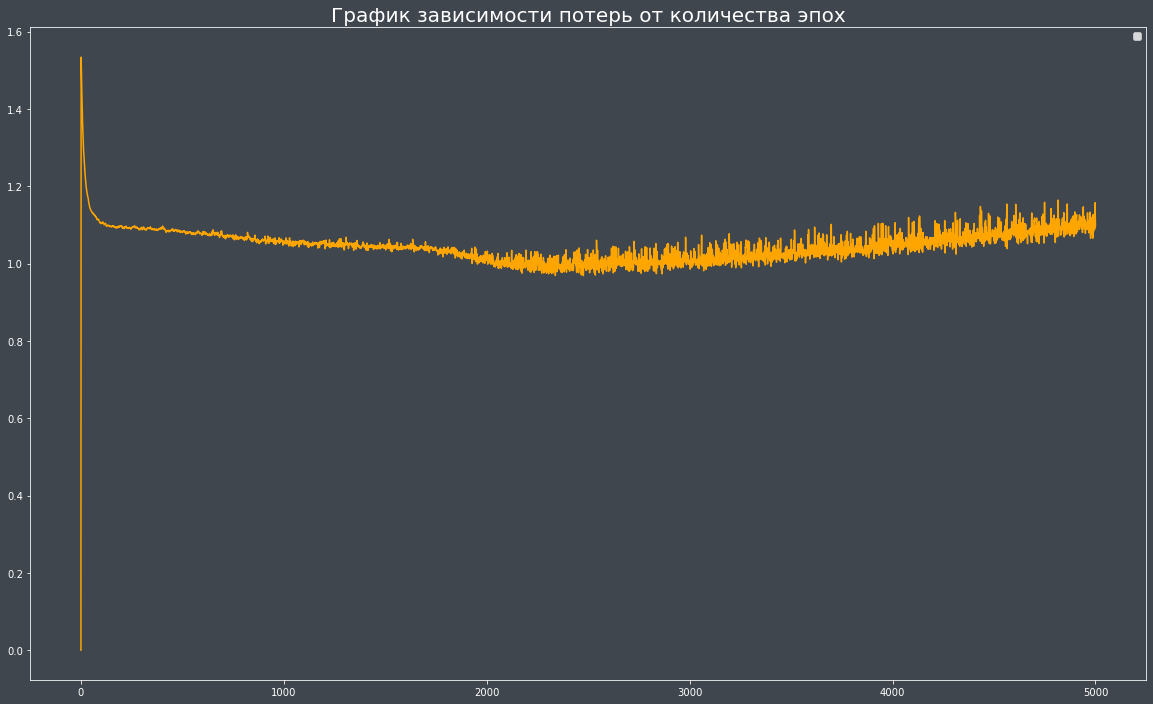

In [148]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
array = np.array(0)
# plt.plot(test_accuracy_history, color = 'orange')
for i in test_loss_history:
    array = np.append(array, i.detach().numpy())
plt.plot(array, color = 'orange')
plt.title(u"График зависимости потерь от количества эпох", fontsize=20, color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
fig.patch.set_facecolor('#3f464e')
ax.patch.set_facecolor('#3f464e')
plt.legend()



In [150]:
preds = cluster.inference(X_test)
preds = preds.argmax(dim=1)
preds

tensor([1, 1, 1, 2, 1, 3, 2, 3, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 1, 3, 1, 3, 2, 3, 1, 1, 2, 2, 3, 2, 2])